In [1]:
%matplotlib notebook

import re
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pockpy

# NOTE: This notebook assumes access to AFS

### Short summary of contents

This notebook showcases how the orbit corrector budget can be verified under some minimal assumptions on the errors. The scenario shown here assumes that the error correction takes place with perfect BPMs that are perfectly aligned with respect to the reference (ideal) orbit.

In [2]:
# Specify the path to a MAD-X job defining HL-LHC optics
madx_filename = '/afs/cern.ch/eng/lhc/optics/HLLHCV1.5/examples/job_round.madx'

# Here we enforce that the optics are aggressively sliced, this makes the error response matrix slightly more
# accurate and assures that any knob based on shifting quadrupoles will be physically correct.
makethin_option_li = [
    {
        'slice' : 10,
        'pattern' : '^MQ.*'
    },
    {
        'slice' : 30,
        'pattern' : '^MQXF.*'
    }
]

# Load the given optics into the Solver..
solver = pockpy.Solver(
    madx_filename=madx_filename,
    makethin_option_li=makethin_option_li
)

# ..and build the response matrix for the section Q25 -> Q25 around IP5
section = {
    'LHCB1' : ('MQ.25L5.B1', 'MQ.25R5.B1'),
    'LHCB2' : ('MQ.25L5.B2', 'MQ.25R5.B2')
}
solver.build_matrices(section=section, concatenate_elements=True)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.03.31 13:04:17      +
  ++++++++++++++++++++++++++++++++++++++++++++
option, warn,info;

system,"rm -rf temp"; system,"mkdir temp";

system,"ln -fns /afs/cern.ch/eng/lhc/optics/HLLHCV1.5 slhc";

system,"ln -fns /afs/cern.ch/eng/lhc/optics/runIII lhc";



Option, -echo,-warn,-info;

++++++ warning: implicit element re-definition ignored: marks.l1
++++++ warning: implicit element re-definition ignored: marke.l1
++++++ warning: implicit element re-definition ignored: marke.r1
++++++ warning: implicit element re-definition ignored: marks.r1
++++++ warning: implicit element re-definition ignored: marks.l5
++++++ warning: implicit element re-definition ignored: marke.l5
++++++ warning: implicit element re-definition ignored: marke.r5
++++++ warning: implicit element re-definition i

makethin: style chosen : teapot
makethin: slicing sequence : lhcb1
enter Twiss module

++++++ table: summ

length orbit5 alfa gammatr 
26658.8831999985 -0 0.000349194613799183 53.513854300159 

q1 dq1 betxmax dxmax 
62.3093309478086 -350.888155088252 21594.1821571285 7.24765488443679 

dxrms xcomax xcorms q2 
1.83856103648771 0.0146243862380016 0.00201894850081507 60.3193478042183 

dq2 betymax dymax dyrms 
-347.708979516932 21628.998255404 8.34389430059264 1.47873544595904 

ycomax ycorms deltap synch_1 
0.0146760350989173 0.0019353608942364 0 0 

synch_2 synch_3 synch_4 synch_5 
0 0 0 0 

nflips 
0 
makethin: style chosen : teapot
makethin: slicing sequence : lhcb2
enter Twiss module

++++++ table: summ

length orbit5 alfa gammatr 
26658.8831999985 -0 0.000348409254527586 53.5741339050182 

q1 dq1 betxmax dxmax 
62.3093381620875 -350.670484619026 21665.1596624389 8.45308759122636 

dxrms xcomax xcorms q2 
2.08261590555513 0.0145894126581595 0.0020504966265712 60.319342622109 

dq2 be

In [3]:
# Add the following errors..
error_dict = {
    'QUADRUPOLE' : { 
        '.*' : {
            'DX' : 5e-4, 
            'DY' : 5e-4,
            'DPSI' : 1e-3,
            'DKR1' : 2e-3
        }
    },
    'DIPOLE' : {
        '.*' : {
            'DKR0' : 2e-3,
            'DPSI' : 5e-4,
            'DX' : 5e-4, 
            'DY' : 5e-4
        }
    }
}

# .. to all elements Q20->Q20
element_range = {
    'LHCB1' : ('MQ.20L5.B1', 'MQ.20R5.B1'),
    'LHCB2' : ('MQ.20L5.B2', 'MQ.20R5.B2')
}
solver.reset_errors()
solver.add_errors(errors=error_dict, element_range=element_range)

In [4]:
# Define which BPMs/planes need to be corrected to zero in the correction
correct_at = {
    'LHCB1': {
        'BPMQSTZA.1L5.B1' : ['X', 'Y'],
        'BPMQSTZA.1R5.B1' : ['X', 'Y'],
        'BPMQBCZA.4L5.B1' : ['X', 'Y'],
        'BPMQBCZB.4R5.B1' : ['X', 'Y'],
        'BPMYA.4L5.B1' : ['X', 'Y'],
        'BPMYA.4R5.B1' : ['X', 'Y'],
        'BPM.23L5.B1' : ['X', 'Y'],
        'BPM.23R5.B1' : ['X', 'Y'],
        'BPM.24L5.B1' : ['X', 'Y'],
        'BPM.24R5.B1' : ['X', 'Y']
    },
    'LHCB2': {
        'BPMQSTZA.1L5.B2' : ['X', 'Y'],
        'BPMQSTZA.1R5.B2' : ['X', 'Y'],
        'BPMQBCZB.4L5.B2' : ['X', 'Y'],
        'BPMQBCZA.4R5.B2' : ['X', 'Y'],
        'BPMYA.4L5.B2' : ['X', 'Y'],
        'BPMYA.4R5.B2' : ['X', 'Y'],
        'BPM.23L5.B2' : ['X', 'Y'],
        'BPM.23R5.B2' : ['X', 'Y'],
        'BPM.24L5.B2' : ['X', 'Y'],
        'BPM.24R5.B2' : ['X', 'Y']
    }
}

## Perform a linear correction

In [5]:
# We need to define a weighting of the pseudoinverse matrix

# To do this, we first split all active BPMs into arc and triplet BPMs
bpm_li = solver.get_bpm_list()

# Here the triplet BPMs are hardcoded. They can also be found by slicing the Twiss table appropriately.
all_bpms = solver.get_bpm_list()
triplet_bpms = [
     'BPMQSTZB.4L5.B1',
     'BPMQSTZB.B3L5.B1',
     'BPMQSTZB.A3L5.B1',
     'BPMQSTZB.B2L5.B1',
     'BPMQSTZB.A2L5.B1',
     'BPMQSTZA.1L5.B1',
     'BPMQSTZA.1R5.B1',
     'BPMQSTZB.A2R5.B1',
     'BPMQSTZB.B2R5.B1',
     'BPMQSTZB.A3R5.B1',
     'BPMQSTZB.B3R5.B1',
     'BPMQSTZB.4R5.B1',
     'BPMQSTZB.4L5.B2',
     'BPMQSTZB.B3L5.B2',
     'BPMQSTZB.A3L5.B2',
     'BPMQSTZB.B2L5.B2',
     'BPMQSTZB.A2L5.B2',
     'BPMQSTZA.1L5.B2',
     'BPMQSTZA.1R5.B2',
     'BPMQSTZB.A2R5.B2',
     'BPMQSTZB.B2R5.B2',
     'BPMQSTZB.A3R5.B2',
     'BPMQSTZB.B3R5.B2',
     'BPMQSTZB.4R5.B2',
]
arc_bpms = [x for x in all_bpms if x not in triplet_bpms]

# Now, define the weighting
bpm_weighting = solver.get_bpm_reading_series()
bpm_weighting.loc[:, :, triplet_bpms] = 1.25e-6
bpm_weighting.loc[:, :, arc_bpms] = 1e-6

# And lastly, perform the linear correction
cs, residual = solver.linear_correction(correct_at=correct_at, mode='rms', bpm_scaling=bpm_weighting, n_x=47)

<IPython.core.display.Javascript object>


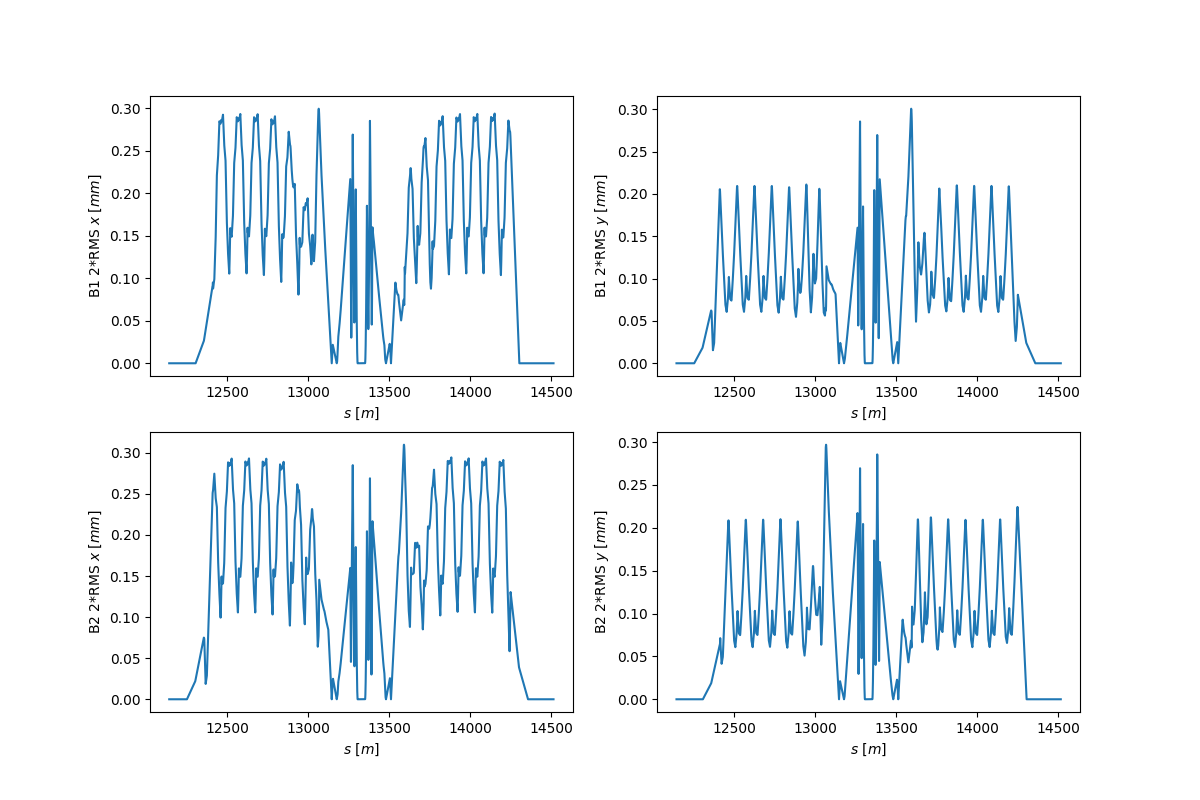

In [6]:
# Show the 2*RMS residual after a correction 
tt = solver.twiss_table

beams = ['LHCB1', 'LHCB2']
planes = 'XY'

plt.figure(figsize=(12, 8))
i = 1
for beam, plane in itertools.product(beams, planes):
    plt.subplot(2, 2, i)
    i += 1
    
    s = tt.loc[beam]['S']
    plt.plot(s, 2e3*residual.loc[beam, plane, :])
    plt.xlabel('$s$ [$m$]')
    plt.ylabel(f'{beam[-2:]} 2*RMS ${plane.lower()}$ [$mm$]')
plt.show()

<IPython.core.display.Javascript object>


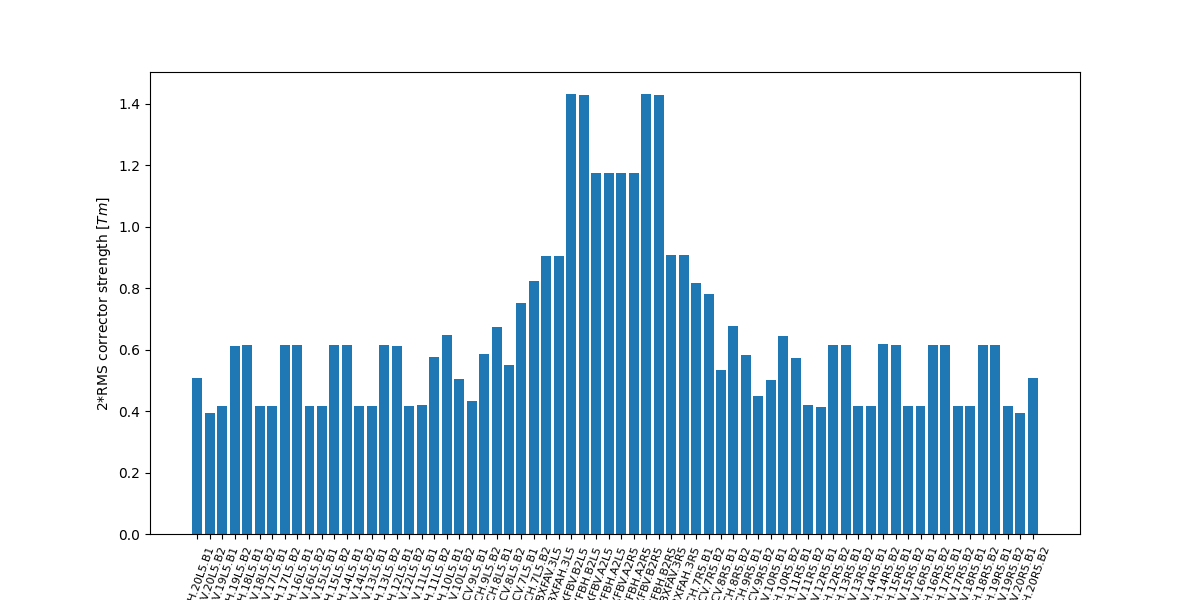

In [7]:
# Show the 2*RMS corrector strength used

plt_cs = cs[cs.abs() > 0.1]

bars = [x for x in range(plt_cs.shape[0])]

plt.figure(figsize=(12,6))
plt.bar(bars, 2*plt_cs)
plt.xticks(bars, plt_cs.index, rotation=70, fontsize=8)
plt.ylabel('2*RMS corrector strength [$Tm$]')
plt.show()

## Solve the knob implementation while reserving the 2\*RMS corrector strength

In [8]:
# We define the corrector strength bounds
regexp_to_lim = {r'^MCB[HV]' : 1.895,
                 r'MCBC[HV].[78]' : 2.8,
                 r'MCBC[HV].[56]' : 2.1,
                 r'MCBY[HV].[AB]?4' : 2.25,
                 r'MCBRD[HV]' : 5,
                 r'MCBXFA[HV].3' : 4.5,
                 r'MCBXFB[HV].[AB][12]' : 2.5,
                 r'MCBW[HV]' : 1.87,
                 r'MCBC[HV].9' : 1.895
}
cs_limit = solver.get_corrector_series()
for pattern, limit in regexp_to_lim.items():
    elements = [c for c in cs_limit.index if re.search(pattern, c)]
    cs_limit.loc[elements] = limit
    
# And we reserve the 2*RMS corrector strength necessary for the linear correction
knob_cs_bound = cs_limit - 2*cs

# Define the weighting for the corrector strength optimization
knob_corrector_weight = solver.get_corrector_series()
minimize_these = [c for c in knob_corrector_weight.index if bool(re.search('^MCBY',c))]
knob_corrector_weight.loc[minimize_these] = 1.0


knob_cs_df, knob_df = solver.knob_implementation(cs_bound=knob_cs_bound, 
                                                 c_weight=knob_corrector_weight)
knob_cs_df['$2\sigma$ CORRECTION'] = 2*cs

<IPython.core.display.Javascript object>


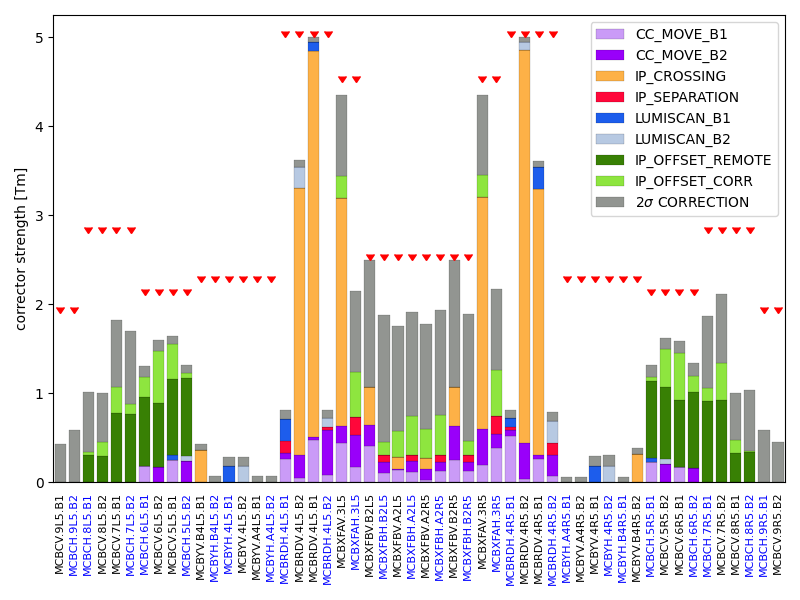

In [9]:
plt.figure(figsize=(8,6))
bars = np.array(list(knob_cs_df.index))

plt.rcParams.update({'font.size': 10})

styling = {
    'LUMISCAN_B1' : {'color' : 'xkcd:azul'},
    'LUMISCAN_B2' : {'color' : 'xkcd:light blue grey'},
    'IP_CROSSING' : {'color' : 'xkcd:butterscotch'},
    'IP_SEPARATION' : {'color' : 'xkcd:neon red'},
    'IP_OFFSET_REMOTE' : {'color' : 'xkcd:dark grass green'},
    'IP_OFFSET_CORR' : {'color' : 'xkcd:kiwi green'},
    'CC_MOVE_B1' : {'color' : 'xkcd:baby purple'},
    'CC_MOVE_B2' : {'color' : 'xkcd:vivid purple'},
    '$2\sigma$ CORRECTION' : {'color' : 'xkcd:gray'}
}

tot_bar = pd.Series(0.0, index=knob_cs_df.index)
for col in knob_cs_df:
    plt.bar(bars, knob_cs_df[col].abs(), bottom=tot_bar, label=col, **styling[col], edgecolor='k', linewidth=0.1)
    tot_bar += knob_cs_df[col].abs()

plt.plot(bars, cs_limit, marker=7, color='red', ls='', ms=6)

plt.xticks(bars, knob_cs_df.index, rotation=90, fontsize=8)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

# Color!
[i.set_color("blue") for i in plt.gca().get_xticklabels() if 'H' in str(i)]
plt.xlim(31+0.5, 84-0.5)


plt.ylabel('corrector strength [Tm]')
plt.legend(loc='upper right')

plt.tight_layout()


plt.show()


<IPython.core.display.Javascript object>


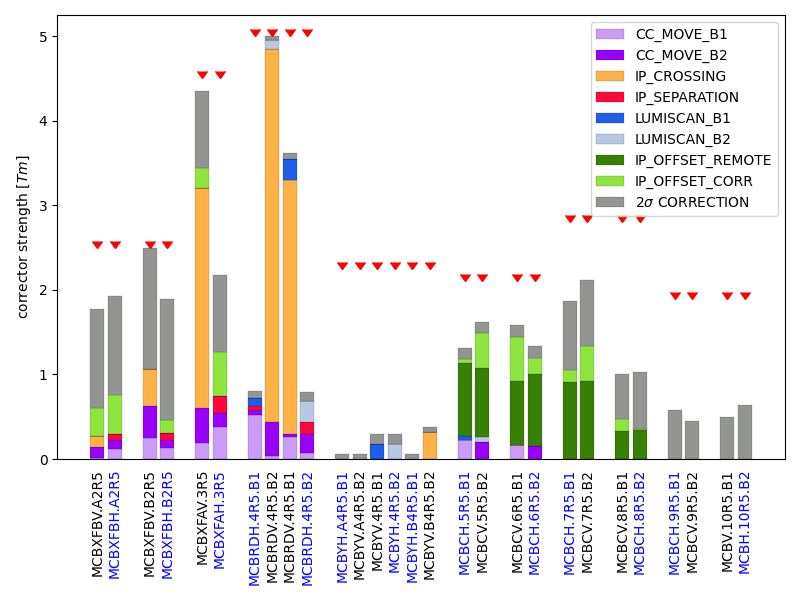

In [10]:
group_patterns=[r'\.A2R', r'\.B2R', r'\.3R', r'MCBRD[HV]\.4R', r'MCBY[HV]\.[AB]?4R',
                r'\.5R', r'\.6R', r'\.7R', r'\.8R', r'\.9R', r'\.10R']

plt.rcParams.update({'font.size': 10})

styling = {
    'LUMISCAN_B1' : {'color' : 'xkcd:azul'},
    'LUMISCAN_B2' : {'color' : 'xkcd:light blue grey'},
    'IP_CROSSING' : {'color' : 'xkcd:butterscotch'},
    'IP_SEPARATION' : {'color' : 'xkcd:neon red'},
    'IP_OFFSET_REMOTE' : {'color' : 'xkcd:dark grass green'},
    'IP_OFFSET_CORR' : {'color' : 'xkcd:kiwi green'},
    'CC_MOVE_B1' : {'color' : 'xkcd:baby purple'},
    'CC_MOVE_B2' : {'color' : 'xkcd:vivid purple'},
    '$2\sigma$ CORRECTION' : {'color' : 'xkcd:gray'}
}

corrector_to_idx={}
idx = 0
pos = 0
bars = []
for pattern in group_patterns:
    for c in solver.corrector_response_matrix.columns:
        if bool(re.search(pattern, c)):
            corrector_to_idx[c] = idx
            bars.append(pos)
            idx += 1
            pos += 1
    pos += 1

n = len(bars)
tot_bar = np.zeros(n)

plt.figure(figsize=(8, 6))

for col in knob_cs_df:
    temp_bar = np.zeros(n)
    for c, val in knob_cs_df[col].items():
        if c in corrector_to_idx:
            temp_bar[corrector_to_idx[c]] += abs(val)
    plt.bar(bars, temp_bar, bottom=tot_bar, label=col, **styling[col], edgecolor='black', linewidth=0.1)
    tot_bar += temp_bar

marker_vals = np.zeros(n)

for c, idx in corrector_to_idx.items():
    plt.plot(bars[idx], cs_limit[c], marker=7, color='red', ls='', ms=7)

labels = [''] * n
for c, idx in corrector_to_idx.items():
    labels[idx] = c

plt.xticks(bars, labels, rotation=90, fontsize=10)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

# Color!
[i.set_color("blue") for i in plt.gca().get_xticklabels() if 'H' in str(i)]

plt.ylabel('corrector strength [$Tm$]')
plt.legend(loc='upper right')

plt.tight_layout()

plt.show()


<IPython.core.display.Javascript object>


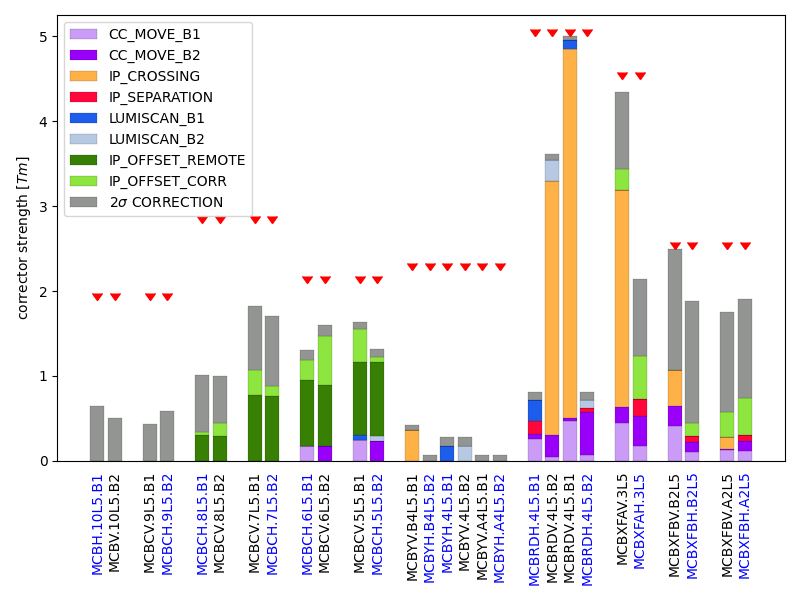

In [11]:
group_patterns=[r'\.A2L', r'\.B2L', r'\.3L', r'MCBRD[HV]\.4L', r'MCBY[HV]\.[AB]?4L',
                r'\.5L', r'\.6L', r'\.7L', r'\.8L', r'\.9L', r'\.10L']
group_patterns.reverse()


plt.rcParams.update({'font.size': 10})

styling = {
    'LUMISCAN_B1' : {'color' : 'xkcd:azul'},
    'LUMISCAN_B2' : {'color' : 'xkcd:light blue grey'},
    'IP_CROSSING' : {'color' : 'xkcd:butterscotch'},
    'IP_SEPARATION' : {'color' : 'xkcd:neon red'},
    'IP_OFFSET_REMOTE' : {'color' : 'xkcd:dark grass green'},
    'IP_OFFSET_CORR' : {'color' : 'xkcd:kiwi green'},
    'CC_MOVE_B1' : {'color' : 'xkcd:baby purple'},
    'CC_MOVE_B2' : {'color' : 'xkcd:vivid purple'},
    '$2\sigma$ CORRECTION' : {'color' : 'xkcd:gray'}
}

corrector_to_idx={}
idx = 0
pos = 0
bars = []
for pattern in group_patterns:
    for c in solver.corrector_response_matrix.columns:
        if bool(re.search(pattern, c)):
            corrector_to_idx[c] = idx
            bars.append(pos)
            idx += 1
            pos += 1
    pos += 1

n = len(bars)
tot_bar = np.zeros(n)

plt.figure(figsize=(8, 6))

for col in knob_cs_df:
    temp_bar = np.zeros(n)
    for c, val in knob_cs_df[col].items():
        if c in corrector_to_idx:
            temp_bar[corrector_to_idx[c]] += abs(val)
    plt.bar(bars, temp_bar, bottom=tot_bar, label=col, **styling[col], edgecolor='black', linewidth=0.1)
    tot_bar += temp_bar

marker_vals = np.zeros(n)

for c, idx in corrector_to_idx.items():
    plt.plot(bars[idx], cs_limit[c], marker=7, color='red', ls='', ms=7)

labels = [''] * n
for c, idx in corrector_to_idx.items():
    labels[idx] = c

plt.xticks(bars, labels, rotation=90, fontsize=10)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

# Color!
[i.set_color("blue") for i in plt.gca().get_xticklabels() if 'H' in str(i)]

plt.ylabel('corrector strength [$Tm$]')
plt.legend(loc='upper left')

plt.tight_layout()

plt.show()


<IPython.core.display.Javascript object>


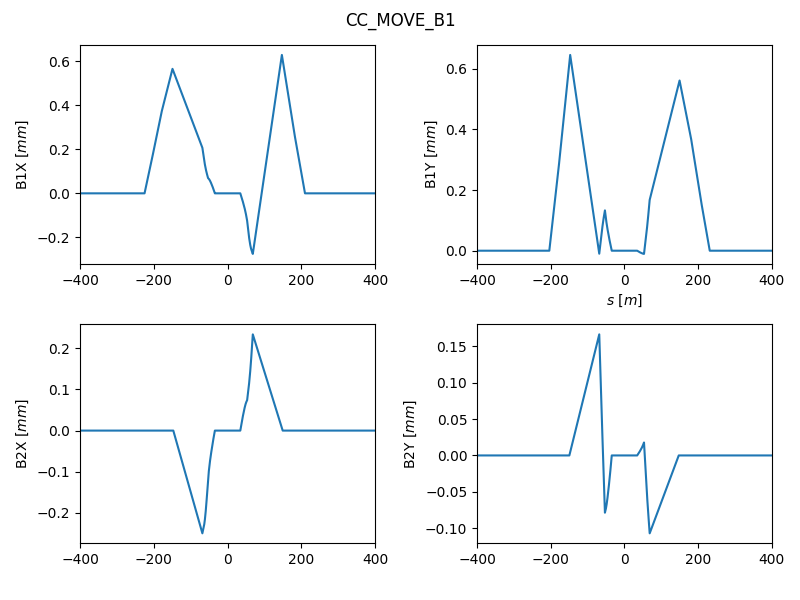

<IPython.core.display.Javascript object>


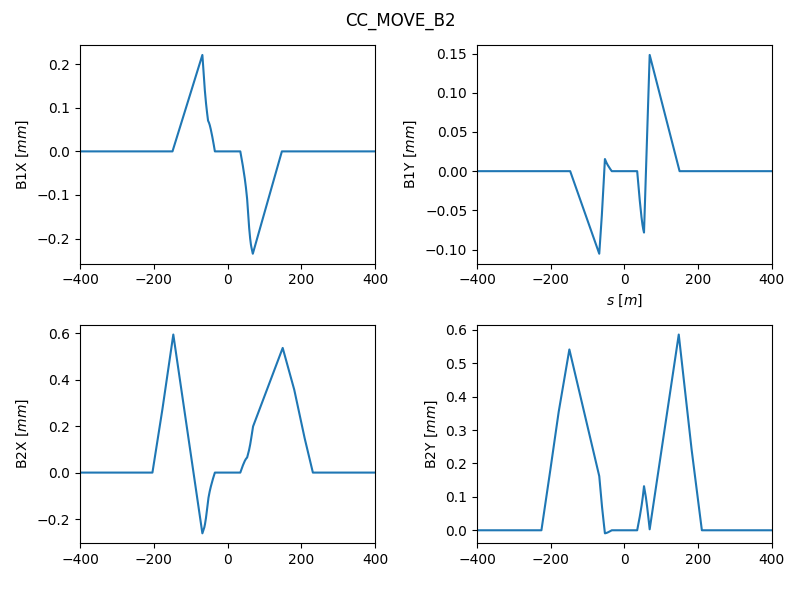

<IPython.core.display.Javascript object>


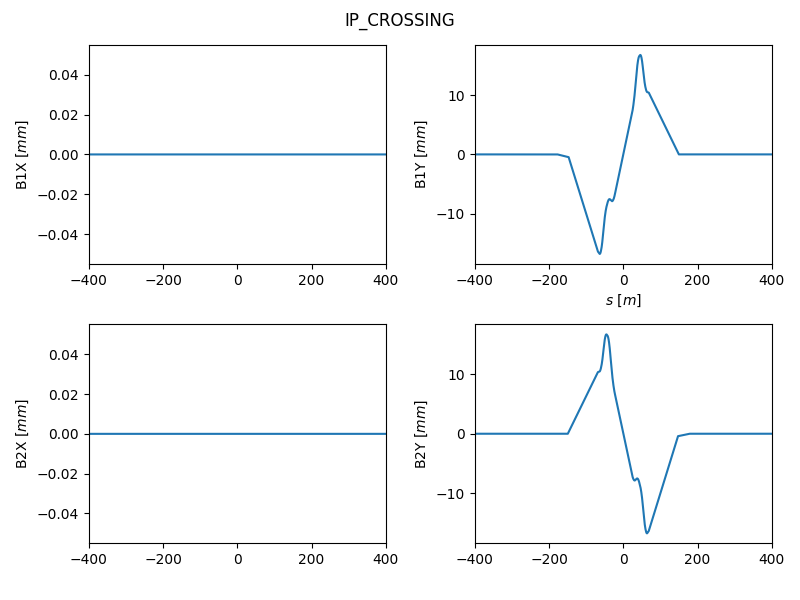

<IPython.core.display.Javascript object>


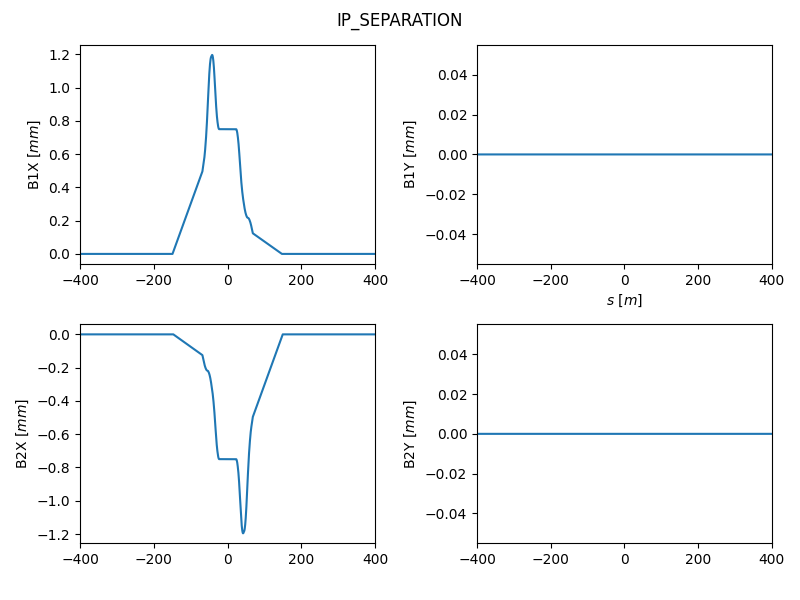

<IPython.core.display.Javascript object>


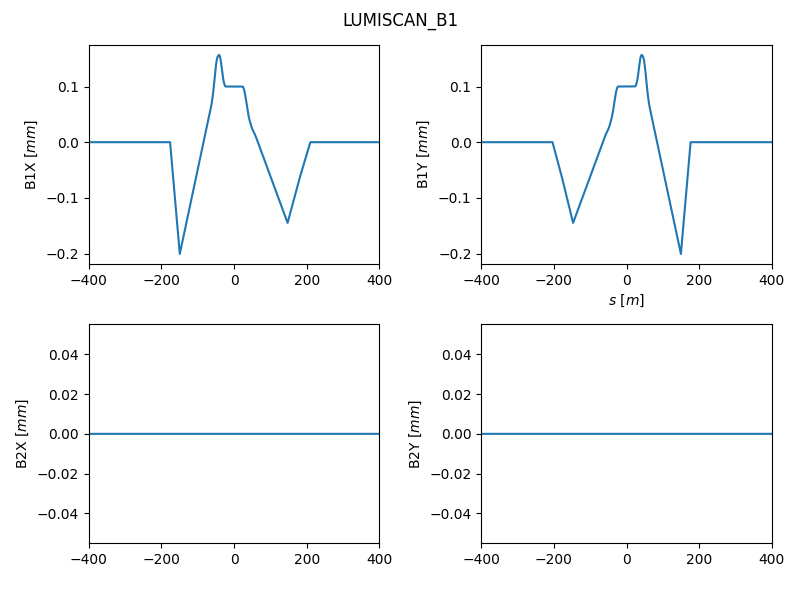

<IPython.core.display.Javascript object>


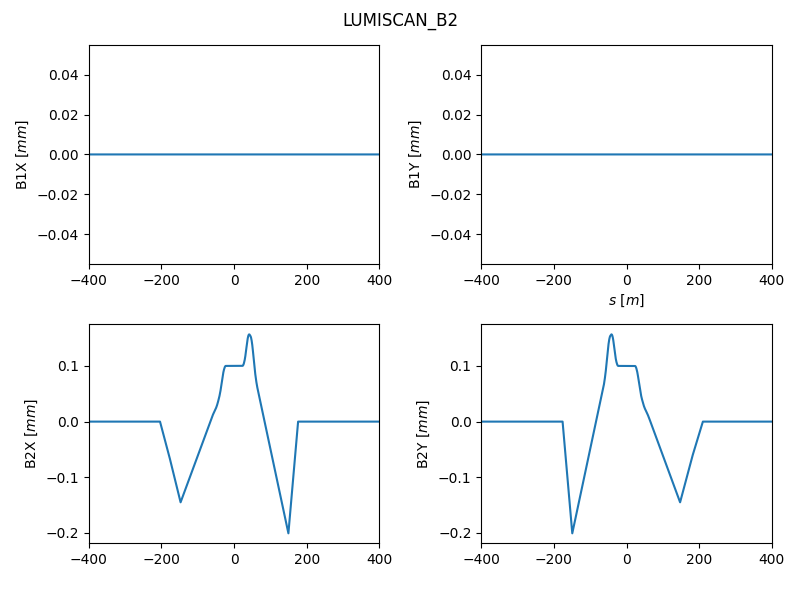

<IPython.core.display.Javascript object>


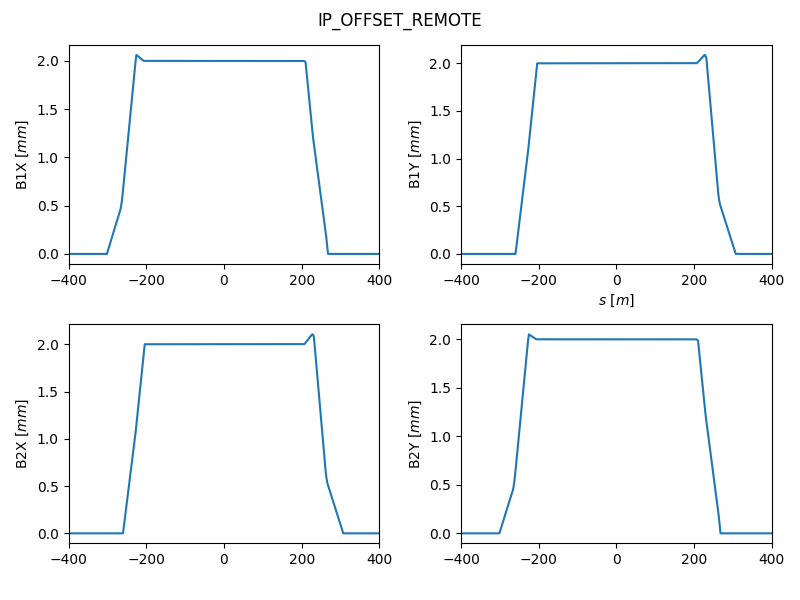

<IPython.core.display.Javascript object>


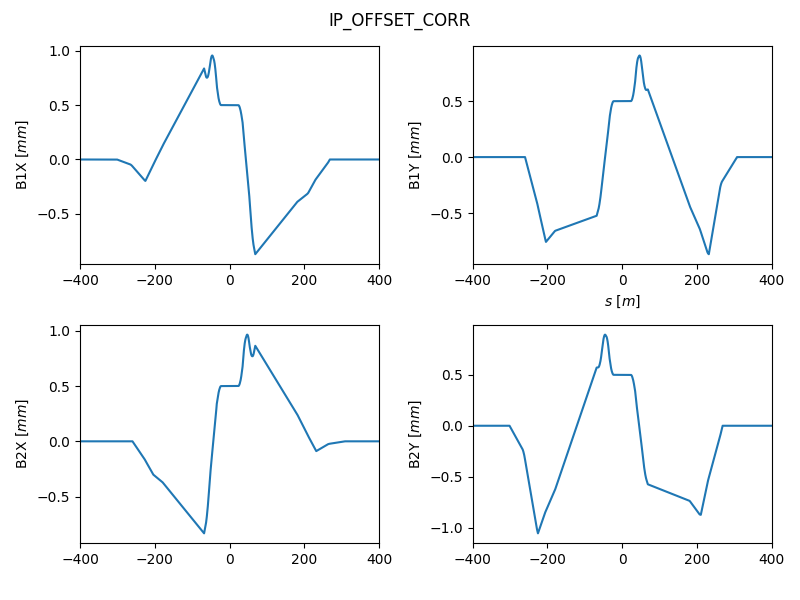

In [12]:
beam = 'LHCB1'
plane = 'X'

for knob in knob_df:
    i = 0
    plt.figure(figsize=(8,6))
    for beam in ['LHCB1', 'LHCB2']:
        plt.xlabel('$s$ [$m$]')

        s = tt.loc[beam, 'S'] - tt.at[(beam, 'IP5'), 'S']
        for dim in 'XY':
            i += 1
            plt.subplot(2, 2, i)
            plt.plot(s, 1e3*knob_df.loc[(beam, dim), knob])
            plt.ylabel(f'B{beam[-1]}{dim} [$mm$]')
            plt.xlim(-400, 400)

    plt.suptitle(knob)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()